In [1]:
## JAX/NumPyro
import jax
import jax.numpy as jnp
import jax.nn as jnn
from jax import random, tree, vmap, jit, grad
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed
from numpyro.infer import MCMC, NUTS, init_to_sample, init_to_median
from numpyro.infer.reparam import LocScaleReparam
import blackjax
import blackjax.smc.resampling as resampling
from blackjax.smc import extend_params

from jax import config
config.update("jax_enable_x64", True)

## Set number of CPUs to use
numpyro.set_host_device_count(4)
print('Number of CPUs: ', jax.local_device_count())

## Plotting/other packages
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import numpy as np

## ODE solver package (this must be imported after setting the number of CPUs)
import equinox as eqx
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController, ConstantStepSize

## Local packages
import sys
sys.path.append('../')
import hiermodelutils as hmu

## Set random seed (must do this for JAX/NumPyro)
rng_seed = 12345
key, subkey = random.split(random.PRNGKey(rng_seed))

## Set color scheme
colors = ['#a1dab4', '#41b6c4', '#225ea8']

/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of CPUs:  4


# Bayesian Data Analysis for an ODE Model (Mass-Spring-Damper System)

Suppose we have a damper for which we want to determine the damping coefficient, $b$, as a function of temperature, $T$. Suppose also that we only have access to limited, noisy data from a few mass-spring-damper experiments at different ambient temperatures. This notebook illustrates how we might infer the unknown function, $b(T)$, via Bayesian inference.

## The physical model

Consider a mass-spring-damper system where $x$ is position, $t$ is time, $m$ is mass, $k$ is spring constant, $T$ is temperature, $b(T)$ is temperature-dependent damping coefficient, and $f$ is the forcing function. 

![mass-spring-damper-diagram](mass-spring-damper-diagram.png)

We can model this with the following ODE:
$$
\begin{equation}
\left\{
\begin{aligned}
    &m \ddot{x} + b(T) \dot{x} + k x = f \\
    & b(T) = b_\text{max}e^{-k(T - 5)} \\
    &f(t) = A\sin(\omega t) \\
    &x(0) = x_0 \\
    &\dot{x}(0) = v_0
\end{aligned}
\right.
\end{equation}
$$
Let's denote the parameters with $\theta = (m, \beta_0, \beta_1, k, A, \omega)$.

Let $g: \mathbb{R}_+ \times \R \rightarrow \mathbb{R}$ be the solver for (1). That is, $x(t, T) = g(t, T; \theta)$. 

**Let's implement this solver with the [Diffrax package](https://docs.kidger.site/diffrax/):**


## Nondimensionalize

Let 
$
\tilde{t} = \omega_n t, ~~ 
\tilde{x} = \frac{x}{\ell}, ~~
\tilde{\zeta} = \frac{c}{2m\omega_n}, ~~
\tilde{A} = \frac{A}{\ell \omega_n^2}, ~~
\tilde{\omega} = \frac{\omega}{\omega_n}, ~~
\omega_n = \sqrt{\frac{k}{m}}, ~~
$
and
$~
\tilde{T}=\frac{T - T_\text{max}}{T_\text{max} - T_\text{min}}.
$
By applying these substitutions, we can derive a nondimensional version of the model:

$$
\begin{equation}
\left\{
\begin{aligned}
    & \ddot{\tilde{x}} + 2\zeta(\tilde{T}) \dot{\tilde{x}} + \tilde{x} = \tilde{f} \\
    & \zeta(\tilde{T}) = \zeta_\text{max} e^{-\tilde{k}\tilde{T}} \\
    & \tilde{f}(\tilde{t}) = \tilde{A}\sin(\tilde{\omega} \tilde{t}) \\
    &x(0) = \frac{x_0}{\ell} \\
    &\dot{x}(0) = \frac{v_0}{\ell \omega_n}
\end{aligned}
\right.
\end{equation}
$$
Let $\tilde{g}: \mathbb{R}_+ \times [0, 1] \rightarrow \mathbb{R}$ be the solver for (2).

One advantage of this model is that it has less parameters. Another advantage is that we can choose the free parameters $(\ell, T_\text{max}, T_\text{min})$ so that the gradients of the solver are numerically stable.

In [2]:
# Dimensional

@jit
def solve_mass_spring_damper(times, b, theta):
    # Mass-spring-damper
    def rhs(t, x, args):
        p, v = x
        return jnp.array([v, -args['b']/args['m']*v - args['k']/args['m']*p + args['A']*jnp.sin(args['omega']*t)])
    term = ODETerm(rhs)
    solver = Dopri5()
    y0 = jnp.stack([theta['x0'], theta['v0']])
    saveat = SaveAt(ts=times)
    solution = diffeqsolve(term, solver, t0=0, t1=times[-1], dt0=0.01, y0=y0, saveat=saveat, args=dict(**theta, b=b))
    return solution.ys

@jit
def damping_coef(T, theta):
    return theta['max_damping_coef'] - theta['k_damping_coef']*(T - 5.0)

@jit
def g(t, T, theta):
    """Full physical model (deterministic)."""
    b = jnn.softplus(damping_coef(T, theta))
    # jax.debug.print('{b}:', b=b)
    x = solve_mass_spring_damper(t, b, theta)[:, 0]  # Only return position
    return x


# Nondimensional

@jit
def solve_nondim_mass_spring_damper(times, zeta, theta):
    # Non-dimensional mass-spring-damper
    def rhs(t, x, args):
        p, v = x
        return jnp.array([v, -2*args['zeta']*v - p + args['A']*jnp.sin(args['omega']*t)])
    term = ODETerm(rhs)
    solver = Dopri5()
    y0 = jnp.stack([theta['x0'], theta['v0']])
    saveat = SaveAt(ts=times)
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
    solution = diffeqsolve(term, solver, t0=0, t1=times[-1], dt0=0.01, y0=y0, saveat=saveat, stepsize_controller=stepsize_controller, args=dict(**theta, zeta=zeta))
    return solution.ys

@jit
def damping_ratio(T, theta):
    return theta['max_damping_ratio']*jnp.exp(theta['k_damping_ratio']*T)

@jit
def g_nondim(t, T, theta):
    """Full physical model (deterministic)."""
    zeta = damping_ratio(T, theta)
    x = solve_nondim_mass_spring_damper(t, zeta, theta)[:, 0]  # Only return position
    return x

**Let's visualize the result of our solver at 3 different temperatures:**

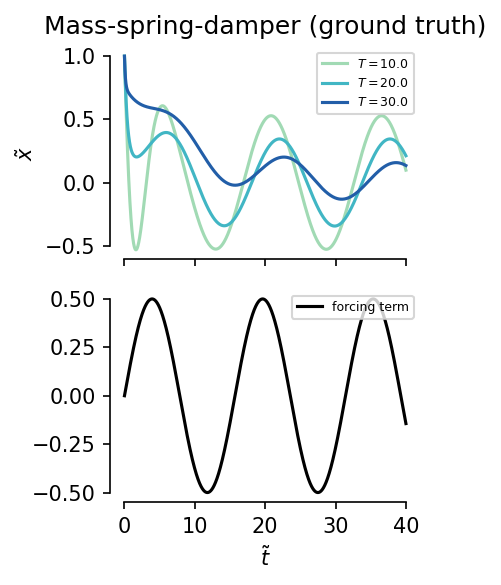

In [3]:
## Define ground truth parameters
T = np.array([10., 20., 30.])
theta_nondim_true = dict(
    x0=1.0,  # nondimensional initial position
    v0=-2.0,  # nondimensional initial velocity
    max_damping_ratio=0.2,
    k_damping_ratio=0.1,
    A=0.5,  # nondimensional forcing amplitude
    omega=0.4  # nondimensional forcing frequency
)

# Evaluate model at range of time points
t_dense = np.arange(0, 40, step=0.001)
x_dense = vmap(g_nondim, (None, 0, None))(t_dense, T, theta_nondim_true)

# Evaluate forcing function
f = lambda t, A, omega: A*jnp.sin(omega*t)
f_dense = vmap(f, (0, None, None))(t_dense, theta_nondim_true['A'], theta_nondim_true['omega'])

# Visualize ground truth
fig, axes = plt.subplots(2, 1, facecolor='white', figsize=(3,4), dpi=150, tight_layout=True, sharex=True)
ax = axes[0]
ax.set_title('Mass-spring-damper (ground truth)')
ax.set_ylabel(r'$\tilde{x}$')
for i in range(3):
    ax.plot(t_dense, x_dense[i], lw=1.5, linestyle='-', color=colors[i], zorder=1, label=r'$T={}$'.format(T[i]))
ax.legend(fontsize=6, loc='upper right')

ax = axes[1]
ax.plot(t_dense, f_dense, lw=1.5, color='black', zorder=0, label='forcing term')
ax.set_xlabel(r'$\tilde{t}$')
ax.legend(fontsize=6, loc='upper right')

sns.despine(trim=True);

## Simulating Measurements

For each temperature $T_i \in \{10, 20, 30\}$, we simulate noisy measurements at random time points $t_{ij}$.

**Let's create the synthetic measurements:**

In [4]:
# Create measurements
meas_params_true = dict(
    sigma=0.05  # measurement noise
)
N_meas_per_temp = 10    # number of measurements (per temperature)
# sigma = 0.08             # measurement uncertainty

mask = (t_dense<20)
ind = np.sort(np.random.randint(1000, 30000, size=(3, N_meas_per_temp)))
t_meas = np.array([t_dense[ind[i]] for i in range(3)])
x_meas = np.array([x_dense[i, ind[i]] for i in range(3)]) + np.random.randn(3, N_meas_per_temp)*meas_params_true['sigma']

**And let's visualize the measurements:**

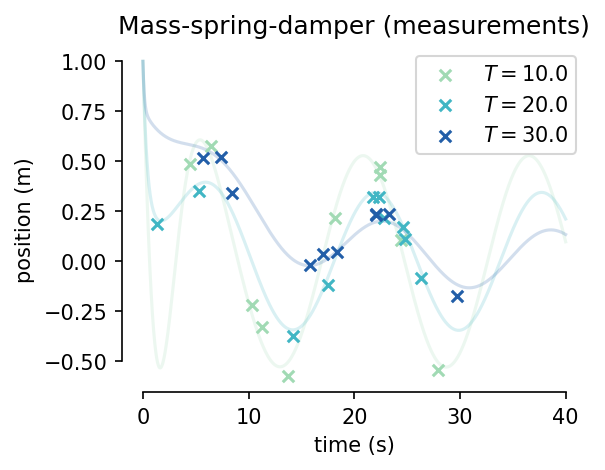

In [5]:
# TODO: Put this dataset at the beginning

# Visualize the measurements
fig, ax = plt.subplots(facecolor='white', figsize=(4,3), dpi=150)
ax.set_title('Mass-spring-damper (measurements)')
ax.set_xlabel('time (s)')
ax.set_ylabel('position (m)')
for i in range(3):
    ax.plot(t_dense, x_dense[i], lw=1.5, linestyle='-', alpha=0.2, color=colors[i], zorder=1)    
    ax.scatter(t_meas[i], x_meas[i], 30, lw=1.5, marker='x', facecolor=colors[i], zorder=100, label=r'$T={}$'.format(T[i]))
ax.legend()
sns.despine(trim=True);

## Probabilistic model

Let's put weakly informative priors on the physical parameters:
$$
\begin{align*}
    \tilde{A} \sim \text{HalfNormal}(0, 1) \\
    \tilde{\omega} \sim \text{HalfNormal}(0, 1) \\
    \zeta_\text{max} \sim \text{HalfNormal}(0, 1) \\
    \tilde{k} \sim \text{HalfNormal}(0, 1) \\
    x_0 \sim \text{Normal}(0, 1) \\
    v_0 \sim \text{Normal}(0, 1) \\
\end{align*}
$$

We group these parameters as $\theta = (\tilde{A}, \tilde{\omega}, \zeta_\text{max}, \tilde{k}, x_0, v_0)$. Let the measurement noise be:

$$
\begin{align*}
    \sigma \sim \text{HalfNormal}(0, 0.1)
\end{align*}
$$

Let the likelihood be:

$$
\begin{align*}
    p(d|\theta, \sigma) = \prod_{i=1}^3 \prod_{j=1}^{N_{\text{meas}}} \mathcal{N}\Big( d_{ij} \Big| g(t_{ij}, T_i; \theta), \sigma^2 \Big)
\end{align*}
$$

We want to characterize the posterior distribution:

$$
\begin{align*}
    p(\theta, \sigma | d) &\propto p(d|\theta, \sigma) p(\theta) p(\sigma)
\end{align*}
$$

In [6]:
from typing import NamedTuple

class Params(NamedTuple):
    x0: float
    v0: float
    max_damping_ratio: float
    k_damping_ratio: float
    A: float
    omega: float
    sigma: float

In [7]:
def prior():
    # with numpyro.handlers.reparam(config={'beta_0': LocScaleReparam(centered=0)}):
    #     # IMPORTANT: Reparameterization!!!
    #     # Behind the scenes, numpyro is actually sampling the transformed variable beta_0_decentered ~ N(0,1).
    #     # A deterministic mapping beta_0 = mu + beta_0_decentered * sigma is then applied to get the actual beta_0.
    #     # This is called the "reparameterization trick". It helps the posterior have a "nicer" shape, which makes it
    #     # easier to sample from.
    #     beta_0 = numpyro.sample('beta_0', beta_0_prior) 

    # return theta
    # A = numpyro.sample('A', dist.HalfNormal(1.0))
    # omega = numpyro.sample('omega', dist.LogNormal(0.5, 1.0))
    # A = 0.5
    # omega = 0.4#jnp.full_like(A, 0.4)
    # max_damping_ratio = numpyro.sample('max_damping_ratio', dist.HalfNormal(0.2))
    # k_damping_ratio = numpyro.sample('k_damping_ratio', dist.HalfNormal(0.1))
    x0 = numpyro.sample('x0', dist.Normal(0.0, 1.0))
    v0 = numpyro.sample('v0', dist.Normal(0.0, 1.0))
    # sigma = numpyro.sample('sigma', dist.HalfNormal(0.1))
    return locals()
    # return dict(
    #     A=A,
    #     omega=omega,
    #     max_damping_ratio=max_damping_ratio,
    #     k_damping_ratio=k_damping_ratio,
    #     x0=x0,
    #     v0=v0,
    #     sigma=sigma
    # )


# TODO: The numpyro functions that get log density values only work when only sampled values are passed into params.
def likelihood(params, T=None, t_meas=None, x_meas=None):
    # Organize parameters
    theta = dict(
        # nondimensional initial position
        x0=params['x0'],
        # nondimensional initial velocity
        v0=params['v0'],
        # max damping ratio
        max_damping_ratio=theta_nondim_true['max_damping_ratio'],
        # rate of damping ratio decay
        k_damping_ratio=theta_nondim_true['k_damping_ratio'],
        # nondimensional forcing amplitude
        A=theta_nondim_true['A'],
        # nondimensional forcing frequency
        omega=theta_nondim_true['omega']
    )

    # Evaluate likelihood
    with numpyro.plate('temperature', T.shape[0], dim=-2): # The plate denotes conditional independence and vectorizes over the specified dimension.
        with numpyro.plate('time', t_meas.shape[1], dim=-1):
            # Evaluate physical model
            # print('theta:', theta)
            # jax.debug.print('{x}', x=theta)
            # theta_in_axes = dict(x0=0, v0=0, max_damping_ratio=None, k_damping_ratio=None, A=None, omega=None)
            x = vmap(g_nondim, (0, 0, None))(t_meas, T, theta)
            return numpyro.sample('obs', dist.Normal(x, meas_params_true['sigma']), obs=x_meas) # The `obs=x_meas` is how we tell NumPyro what the data are.

def model(T=None, t_meas=None, x_meas=None):
    prior_samples = prior()
    likelihood_samples = likelihood(prior_samples, T, t_meas, x_meas)
    return prior_samples, likelihood_samples

In [8]:
with numpyro.handlers.seed(rng_seed=1):
    s_ = prior()
    s = model(T=T, t_meas=t_meas, x_meas=None)

<!-- ## Probabilistic Model Definition

First, we need to encode our prior knowledge into probability distributions over our unknown physical parameters in $\theta$. Since this is just a toy problem, I will just pick some weakly-informative priors. Let
$$
\begin{align*}
&\beta_0 \sim \mathcal{N}\left(0,10\right) \\
&\beta_1^* \sim \mathcal{N}\left(0, 1\right) \\
&\beta_1 = |\beta_1^*| \\
&\ln k \sim \mathcal{N}\left(2, 1\right)
\end{align*}
$$
and let the measurement noise be
$$
\sigma \sim \text{Exponential}\left(5\right)
$$

Let $d$ be our measurements. The posterior we would like to characterize is
$$
\begin{align*}
p(\theta, \sigma | d) &\propto p(d|\theta, \sigma) p(\theta) p(\sigma)
\end{align*}
$$
where the likelihood is given by i.i.d. Gaussians, i.e.,
$$
p(d|\theta, \sigma) = \prod_{i=1}^3 \prod_{j=1}^{N_{\text{meas}}} \mathcal{N}\Big( d_{ij} \Big| g(t_{ij}, T_i; \theta), \sigma^2 \Big)
$$

**We can represent the model with a directed acyclic graph showing the causal structure:**

![dag](dag-for-bda-mass-spring-damper.jpg)

**Let's create our model in Numpyro:** -->

In [57]:
import jax.flatten_util

gen_mod = hmu.get_generative_model(
    prior,
    likelihood,
    likelihood_kwargs=dict(T=T, t_meas=t_meas, x_meas=x_meas)
)
_, unravel_params = jax.flatten_util.ravel_pytree(gen_mod.prior.init_params.z)
ravel_params = lambda x: jax.flatten_util.ravel_pytree(x)[0]
make_array_input_fn = lambda f: lambda x: f(unravel_params(x))

In [56]:
vmap(unravel_params)(jnp.zeros((5, 2)))
vmap(ravel_params)(dict(x0=jnp.zeros(5), v0=jnp.zeros(5))).shape

(5, 2)

In [28]:
x0_plt = np.linspace(-2, 2, 100)
v0_plt = np.linspace(-2, 2, 100)
p_plt = gen_mod.joint.logdensity_fn()


TypeError: get_logdensities_and_transforms_from_numpyro.<locals>.<lambda>() missing 1 required positional argument: 'position'

In [29]:
def smc_inference_loop(rng_key, smc_kernel, initial_state):
    """Run the tempered SMC algorithm.

    We run the adaptive algorithm until the tempering parameter lambda reaches the value
    lambda=1.

    """

    def cond(carry):
        i, state, _k = carry
        return state.lmbda < 1

    def one_step(carry):
        i, state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return i + 1, state, k

    n_iter, final_state, _ = jax.lax.while_loop(
        cond, one_step, (0, initial_state, rng_key)
    )

    return n_iter, final_state

In [68]:
# %%time

# Set some options for the SMC algorithm
inv_mass_matrix = jnp.eye(2)
num_particles = 100

hmc_parameters = dict(
    step_size=1e-3, inverse_mass_matrix=inv_mass_matrix, num_integration_steps=5
)
# make_vector_tree_input_function = lambda f: lambda x: f(tree.map(lambda y: jnp.squeeze(y, axis=-1), x))


tempered = blackjax.adaptive_tempered_smc(
    logprior_fn=make_array_input_fn(gen_mod.prior.logdensity_fn),
    loglikelihood_fn=make_array_input_fn(gen_mod.likelihood.logdensity_fn),
    mcmc_step_fn=blackjax.hmc.build_kernel(),
    mcmc_init_fn=blackjax.hmc.init,
    mcmc_parameters=extend_params(hmc_parameters),
    resampling_fn=resampling.systematic,
    target_ess=0.7,
    num_mcmc_steps=2,
)

# NOTE: SMC is sensitive to how we initially seed the space with particles.
#       I think we need to seed via sampling positions on the prior distribution.
key, subkey_init, subkey_sample = jax.random.split(key, 3)
# initial_smc_state = jax.random.multivariate_normal(
#     subkey_init, jnp.zeros([1]) + 0.0, jnp.eye(1)*1000, (n_samples,)
# )
# initial_smc_state = jax.random.uniform(
#     subkey_init, (n_samples, 1), minval=jnp.zeros([1]) - 10.0, maxval=jnp.zeros(1) + 10.0, 
# )
# initial_smc_state = tempered.init({"x": initial_smc_state})
subkey_init1, subkey_init2 = random.split(subkey_init, 2)
initial_smc_state = tempered.init(vmap(ravel_params)(dict(
    x0=dist.Normal(0.0, 1.0).rsample(subkey_init1, (num_particles,)),
    v0=dist.Normal(0.0, 1.0).rsample(subkey_init2, (num_particles,)),
)))
# eqx.tree_pprint(initial_smc_state)
# [ Array([[1.], [1.2], [3.4]]), Array([[50.], [51], [55]]) ]

n_iter, smc_samples = smc_inference_loop(subkey_sample, tempered.step, initial_smc_state)
print("Number of steps in the adaptive algorithm: ", n_iter.item())

Number of steps in the adaptive algorithm:  22


In [235]:
import jax
from jax import numpy as jnp
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools
from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
from blackjax import inner_kernel_tuning
from blackjax.smc.tuning.from_particles import (
    particles_covariance_matrix,
    particles_stds,
    particles_means,
)
from blackjax import adaptive_tempered_smc
from blackjax.smc import resampling as resampling, solver, extend_params
from blackjax import irmh

n_particles = 5000

from jax.scipy.stats import multivariate_normal

def initial_particles_multivariate_normal(dimensions, key, n_samples):
    return jax.random.multivariate_normal(
        key, jnp.zeros(dimensions), jnp.eye(dimensions) * 2, (n_samples,)
    )


def V(x):
    return 5 * jnp.sum(jnp.square(x**2 - 1))


def prior_log_prob(x):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d))


loglikelihood = lambda x: -V(x)

linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)

def density():
    lambdas = jnp.linspace(0.0, 1.0, 5)
    prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
    potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
    log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(
        lambdas, 1
    ) * potential_vals.reshape(1, -1)

    density = jnp.exp(log_res)
    normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (
        linspace[1] - linspace[0]
    )
    density /= normalizing_factor
    return density


def tuned_irmh_loop(kernel, rng_key, initial_state):
    def cond(carry):
        _, state, *_ = carry
        return state.sampler_state.lmbda < 1

    def body(carry):
        i, state, op_key = carry
        op_key, subkey = jax.random.split(op_key, 2)
        state, info = kernel(subkey, state)
        return i + 1, state, op_key

    def f(initial_state, key):
        total_iter, final_state, _ = jax.lax.while_loop(
            cond, body, (0, initial_state, key)
        )
        return total_iter, final_state

    total_iter, final_state = f(initial_state, rng_key)
    return total_iter, final_state.sampler_state.particles


def tuned_irmh_experiment(dimensions, target_ess, num_mcmc_steps):
    kernel = irmh.build_kernel()
    def step_fn(key, state, logdensity, means, stds):
        cov = jnp.square(jnp.diag(stds))
        proposal_distribution = lambda key: jax.random.multivariate_normal(
            key, means, cov
        )

        def proposal_logdensity_fn(proposal, state):
            return jnp.log(
                jax.scipy.stats.multivariate_normal.pdf(
                    state.position, mean=means, cov=cov
                )
            )

        return kernel(key, state, logdensity, proposal_distribution, proposal_logdensity_fn)
            

    kernel_tuned_proposal = inner_kernel_tuning(
        logprior_fn=prior_log_prob,
        loglikelihood_fn=loglikelihood,
        mcmc_step_fn=step_fn,
        mcmc_init_fn=irmh.init,
        resampling_fn=resampling.systematic,
        smc_algorithm=adaptive_tempered_smc,
        mcmc_parameter_update_fn=lambda state, info: extend_params(
                                                                                {"means":particles_means(state.particles),
                                                                                 "stds":particles_stds(state.particles)}),
        initial_parameter_value=extend_params({"means":jnp.zeros(dimensions), "stds":jnp.ones(dimensions) * 2}),
        target_ess=target_ess,
        num_mcmc_steps=num_mcmc_steps,
    )

    return kernel_tuned_proposal, tuned_irmh_loop

def smc_run_experiment(runnable, target_ess, num_mcmc_steps, dimen, key=rng_key):
    key, initial_particles_key, iterations_key = jax.random.split(key, 3)
    initial_particles = initial_particles_multivariate_normal(
        dimen, initial_particles_key, n_particles
    )
    kernel, inference_loop = runnable(dimen, target_ess, num_mcmc_steps)
    _, particles = inference_loop(
        kernel.step, iterations_key, kernel.init(initial_particles)
    )
    return particles

experiment_particles = smc_run_experiment(tuned_irmh_experiment, 0.5, 20, 5)

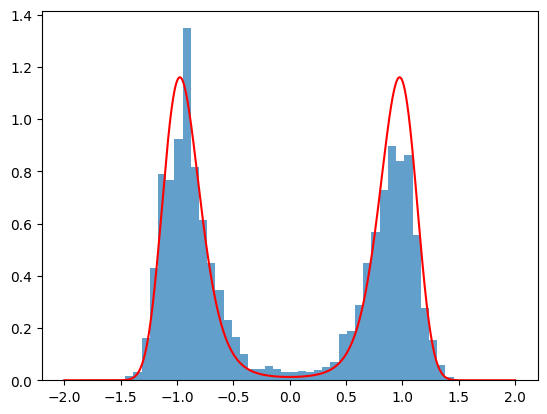

In [236]:
fig, ax = plt.subplots()
# az.plot_kde(experiment_particles[:, 3], ax=ax)
ax.hist(experiment_particles[:, 0], bins=40, density=True, alpha=0.7)
ax.plot(linspace, density()[-1], c="red")

In [237]:
import jax
from jax import numpy as jnp
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools
from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
from blackjax import inner_kernel_tuning
from blackjax.smc.tuning.from_particles import (
    particles_covariance_matrix,
    particles_stds,
    particles_means,
)
from blackjax import adaptive_tempered_smc
from blackjax.smc import resampling as resampling, solver, extend_params
from blackjax import irmh

n_particles = 5000

from jax.scipy.stats import multivariate_normal

def initial_particles_multivariate_normal(dimensions, key, n_samples):
    return jax.random.multivariate_normal(
        key, jnp.zeros(dimensions), jnp.eye(dimensions) * 2, (n_samples,)
    )


def V(x):
    return 5 * jnp.sum(jnp.square(x**2 - 1))


def prior_log_prob(x):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d))


loglikelihood = lambda x: -V(x)

linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)

def density():
    lambdas = jnp.linspace(0.0, 1.0, 5)
    prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
    potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
    log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(
        lambdas, 1
    ) * potential_vals.reshape(1, -1)

    density = jnp.exp(log_res)
    normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (
        linspace[1] - linspace[0]
    )
    density /= normalizing_factor
    return density


def smc_inference_loop(kernel, rng_key, initial_state):
    """Run the tempered SMC algorithm.
    
    Adaptive algorithm is run until the tempering parameter lambda reaches 1.
    """
    def cond(carry):
        _, state, *_ = carry
        return state.sampler_state.lmbda < 1

    def body(carry):
        i, state, key = carry
        key, subkey = jax.random.split(key, 2)
        state, info = kernel(subkey, state)
        return i + 1, state, key

    def f(initial_state, key):
        total_iter, final_state, _ = jax.lax.while_loop(
            cond, body, (0, initial_state, key)
        )
        return total_iter, final_state

    total_iter, final_state = f(initial_state, rng_key)
    return total_iter, final_state.sampler_state.particles


def tuned_hmc_experiment(dimensions, target_ess, num_mcmc_steps):
    hmc_kernel = blackjax.hmc.build_kernel()  # Callable[[PRNGKey, HMCState, *other_hmc_args], HMCState, HMCInfo]
    hmc_init_params = blackjax.smc.extend_params(dict(
        step_size=1e-4,
        inverse_mass_matrix=jnp.ones(dimensions),
        num_integration_steps=50
    ))
    def hmc_param_update_fn(state, info):
        # print(dir(state))
        # print(state.particles.shape)
        # M = jnp.diag(blackjax.smc.tuning.from_particles.mass_matrix_from_particles(state.particles))  # creates a diagonal mass matrix
        particles = blackjax.smc.tuning.from_particles.particles_as_rows(state.particles)
        inv_M_diag = jnp.var(particles, axis=0)
        # jax.debug.print('M={M}', M=M)
        return blackjax.smc.extend_params(dict(
            step_size=1e-3,
            # TODO: Should this be M or 1/M?
            inverse_mass_matrix=inv_M_diag,  # only the diagonal elements
            num_integration_steps=5
        ))
    
    # def step_fn(key, state, logdensity, inv_mass_matrix):
    #     def proposal_logdensity_fn(proposal, state):
    #         return jnp.log(
    #             jax.scipy.stats.multivariate_normal.pdf(
    #                 state.position, mean=means, cov=cov
    #             )
    #         )

    #     return hmc_kernel(key, state, logdensity, proposal_distribution, proposal_logdensity_fn)
            

    kernel_tuned_proposal = inner_kernel_tuning(
        logprior_fn=prior_log_prob,
        loglikelihood_fn=loglikelihood,
        mcmc_step_fn=hmc_kernel,
        mcmc_init_fn=blackjax.hmc.init,
        resampling_fn=blackjax.smc.resampling.systematic,
        smc_algorithm=blackjax.adaptive_tempered_smc,
        mcmc_parameter_update_fn=hmc_param_update_fn,
        initial_parameter_value=hmc_init_params,
        target_ess=target_ess,
        num_mcmc_steps=num_mcmc_steps,
    )

    return kernel_tuned_proposal, tuned_irmh_loop

def smc_run_experiment(runnable, target_ess, num_mcmc_steps, dimen, key=rng_key):
    key, initial_particles_key, iterations_key = jax.random.split(key, 3)
    initial_particles = initial_particles_multivariate_normal(
        dimen, initial_particles_key, n_particles
    )
    kernel, inference_loop = runnable(dimen, target_ess, num_mcmc_steps)
    _, particles = inference_loop(
        kernel.step, iterations_key, kernel.init(initial_particles)
    )
    return particles

experiment_particles = smc_run_experiment(tuned_hmc_experiment, 0.5, 50, 20)

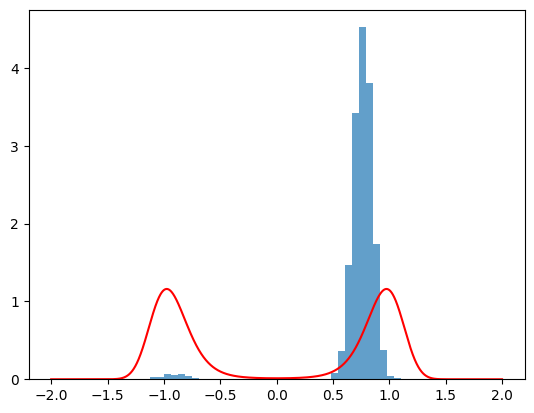

In [238]:
fig, ax = plt.subplots()
# az.plot_kde(experiment_particles[:, 3], ax=ax)
ax.hist(experiment_particles[:, 0], bins=40, density=True, alpha=0.7)
ax.plot(linspace, density()[-1], c="red")

In [21]:
beta_0_prior = dist.Normal(100.0, 20.0)
beta_1_prior = dist.HalfNormal(2.0)
k_prior = dist.Normal(10.0, 1.0)
sigma_prior = dist.Exponential(5)

def pooled_model(T=None, t_meas=None, x_meas=None):
    """Complete-pooled model."""
    
    # Sample priors
    # with numpyro.handlers.reparam(config={'beta_0': LocScaleReparam(centered=0)}):
    #     # IMPORTANT: Reparameterization!!!
    #     # Behind the scenes, numpyro is actually sampling the transformed variable beta_0_decentered ~ N(0,1).
    #     # A deterministic mapping beta_0 = mu + beta_0_decentered * sigma is then applied to get the actual beta_0.
    #     # This is called the "reparameterization trick". It helps the posterior have a "nicer" shape, which makes it
    #     # easier to sample from.
    #     beta_0 = numpyro.sample('beta_0', beta_0_prior) 
    beta_0 = numpyro.sample('beta_0', beta_0_prior) 
    beta_1 = numpyro.sample('beta_1', beta_1_prior)
    k = jnn.softplus(numpyro.sample('k', k_prior))
    sigma = numpyro.sample('sigma', sigma_prior)

    # Organize parameters
    theta = dict(
        m=theta_true['m'], 
        A=theta_true['A'], 
        omega=theta_true['omega'], 
        beta_0=beta_0, 
        beta_1=beta_1,
        k=k
    )

    jax.debug.print('{theta}', theta=theta)

    # Evaluate likelihood
    with numpyro.plate('temperature', x_meas.shape[0], dim=-2): # The plate denotes conditional independence and vectorizes over the specified dimension.
        with numpyro.plate('time', x_meas.shape[1], dim=-1):
            # Evaluate physical model
            x = vmap(g, (0, 0, None))(t_meas, T, theta)
            jax.debug.print('{x}', x=x)
            return numpyro.sample('obs', dist.Normal(x, sigma), obs=x_meas) # The `obs=x_meas` is how we tell NumPyro what the data are.

In [22]:
with numpyro.handlers.seed(rng_seed=10):
    pooled_model(T=T, t_meas=t_meas, x_meas=x_meas)

{'A': Array(0.5, dtype=float32, weak_type=True), 'beta_0': Array(115.95755, dtype=float32), 'beta_1': Array(0.46228606, dtype=float32), 'k': Array(10.875563, dtype=float32), 'm': Array(25., dtype=float32, weak_type=True), 'omega': Array(0.4, dtype=float32, weak_type=True)}
115.95755004882812:
111.33468627929688:
106.71183013916016:
[[-0.1567229  -0.16483244 -0.17029656 -0.18729454 -0.19471256 -0.19521561
   0.1625379   0.16175368  0.14464068  0.10676847]
 [-0.13716823 -0.1459062  -0.17484784 -0.17303061 -0.16397458 -0.03838911
   0.07474047  0.1770209   0.17069793  0.1382498 ]
 [-0.18193367 -0.12177907 -0.12301406 -0.12903602 -0.13984811 -0.06788379
  -0.0411289   0.17251827  0.18318099  0.18435527]]


In [23]:
dist_info = hmu.get_logdensities_and_transforms_from_numpyro(pooled_model, (), dict(T=T, t_meas=t_meas, x_meas=x_meas))

{'A': Array(0.5, dtype=float32, weak_type=True), 'beta_0': Array(-1.0540204, dtype=float32), 'beta_1': Array(0.22435933, dtype=float32), 'k': Array(0.56659204, dtype=float32), 'm': Array(25., dtype=float32, weak_type=True), 'omega': Array(0.4, dtype=float32, weak_type=True)}
0.29901784658432007:
0.03630424290895462:
0.003914120607078075:
[[-0.1702392  -0.14843471 -0.14269897 -0.13170499 -0.12318286 -0.11908585
   0.62820065  0.6347322   0.6884233   0.72855955]
 [-0.17836928 -0.14433008 -0.11159745 -0.10510072 -0.08669926  0.09841956
   0.28758162  0.64938295  0.6741813   0.72496516]
 [-0.31338856 -0.19983363 -0.14620818 -0.13936624 -0.13183774  0.02831986
   0.06788525  0.47469476  0.51186746  0.6826009 ]]
{'A': Array(0.5, dtype=float32, weak_type=True), 'beta_0': Array(-1.0540204, dtype=float32), 'beta_1': Array(0.22435933, dtype=float32), 'k': Array(0.56659204, dtype=float32), 'm': Array(25., dtype=float32, weak_type=True), 'omega': Array(0.4, dtype=float32, weak_type=True)}
0.299017

In [24]:
with numpyro.handlers.seed(rng_seed=10):
    theta_test = {'A': 0.5, 'beta_0': 4.5, 'beta_1': 0.1, 'k': 10.0, 'm': 25., 'omega': 0.4}
    p = grad(dist_info.logdensity_fn)(theta_test)
print(p)

{'A': Array(0.5, dtype=float32, weak_type=True), 'beta_0': Array(4.5, dtype=float32, weak_type=True), 'beta_1': Array(1.105171, dtype=float32, weak_type=True), 'k': Array(10.000046, dtype=float32, weak_type=True), 'm': Array(25., dtype=float32, weak_type=True), 'omega': Array(0.4, dtype=float32, weak_type=True)}
4.511047840118408:
0.0014266538200899959:
2.2642883124035507e-08:
[[0.60270804 0.66889185 0.69013166 0.7360666  0.75929165 0.7660817
  0.9194214  0.9131856  0.8364987  0.7137174 ]
 [0.62880784 0.7388532  0.8542628  0.8627333  0.8805363  0.9823822
  1.0484077  0.97851527 0.9443385  0.8226585 ]
 [0.3236741  0.57223445 0.7303516  0.7587436  0.7948326  0.949408
  0.96842927 1.0668551  1.0609921  0.9319252 ]]
{'A': Array(0., dtype=float32, weak_type=True), 'beta_0': Array(1.4195054, dtype=float32, weak_type=True), 'beta_1': Array(0.6752487, dtype=float32, weak_type=True), 'k': Array(0.93204606, dtype=float32), 'm': Array(0., dtype=float32, weak_type=True), 'omega': Array(0., dtype=f

## Sampling the Posterior

**We now use NumPyro's implementation of the No-U-Turn Sampler (NUTS) to sample from the posterior distribution:**

**Let's visualize the prior distributions against the ground truth:**

In [25]:
# Set up MCMC
nuts_kernel = NUTS(pooled_model, init_strategy=init_to_median())
mcmc = MCMC(nuts_kernel, num_warmup=200, num_samples=400, num_chains=1, progress_bar=True)

# Run MCMC
key, subkey = random.split(key)
mcmc.run(subkey, T=T, t_meas=t_meas, x_meas=x_meas)
mcmc.print_summary()

# Store samples
samples = mcmc.get_samples()
# samples = pd.DataFrame.from_dict(mcmc.get_samples())
# beta_0_post_samp = mcmc.get_samples()['beta_0']
# beta_1_post_samp = mcmc.get_samples()['beta_1']
# k_post_samp = mcmc.get_samples()['k']
# sigma_post_samp = mcmc.get_samples()['sigma']

{'A': Array(0.5, dtype=float32, weak_type=True), 'beta_0': Array(111.15325, dtype=float32), 'beta_1': Array(1.8995298, dtype=float32), 'k': Array(9.924884, dtype=float32), 'm': Array(25., dtype=float32, weak_type=True), 'omega': Array(0.4, dtype=float32, weak_type=True)}
111.15325164794922:
92.15795135498047:
73.16265869140625:
[[-1.73375174e-01 -1.81118399e-01 -1.86463580e-01 -2.03266799e-01
  -2.10670546e-01 -2.11181790e-01  1.58406407e-01  1.57845095e-01
   1.42794773e-01  1.06946632e-01]
 [-8.80401656e-02 -9.07611474e-02 -1.18297197e-01 -1.17006294e-01
  -1.09247610e-01  1.15511985e-02  1.25612676e-01  2.35130325e-01
   2.29108185e-01  1.96338370e-01]
 [-9.10699442e-02  2.81965244e-04  2.02617105e-02  1.77373737e-02
   1.06600067e-02  7.07185492e-02  9.55626220e-02  3.04982245e-01
   3.15784395e-01  3.14383924e-01]]
{'A': Array(0.5, dtype=float32, weak_type=True), 'beta_0': Array(91.11277, dtype=float32), 'beta_1': Array(1.9148003, dtype=float32), 'k': Array(9.570474, dtype=float32

warmup:   0%|          | 1/600 [00:03<34:29,  3.45s/it, 1 steps of size 2.34e+00. acc. prob=0.00]jax.pure_callback failed
Traceback (most recent call last):
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/callback.py", line 86, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/callback.py", line 64, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/equinox/_errors.py", line 70, in raises
    raise EqxRuntimeError(msgs[_index.item()

{'A': Array(0.5, dtype=float32), 'beta_0': Array(89.955734, dtype=float32), 'beta_1': Array(3.205786e+08, dtype=float32), 'k': Array(11.275287, dtype=float32), 'm': Array(25., dtype=float32), 'omega': Array(0.4, dtype=float32)}
[[-0.01939231 -0.02191572 -0.02604451 -0.04223097 -0.05181431 -0.05347122
   0.26435867  0.26315138  0.24106051  0.19527827]
 [ 0.7065805   0.8141594   0.90600204  0.9104137   0.91889274  0.96632636
   0.98997796  0.82499856  0.78097045  0.633387  ]
 [ 0.39429888  0.649532    0.8061103   0.83259434  0.8643054   0.95079875
   0.9598165   0.9652839   0.94989306  0.76534176]]
89.95573425292969:
0.0:
0.0:
{'A': Array(0.5, dtype=float32), 'beta_0': Array(89.370155, dtype=float32), 'beta_1': Array(inf, dtype=float32), 'k': Array(23.687021, dtype=float32), 'm': Array(25., dtype=float32), 'omega': Array(0.4, dtype=float32)}


XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/opt/homebrew/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
  File "/opt/homebrew/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once
  File "/opt/homebrew/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/var/folders/qd/nzzrspw15ks3cp9_3_d2k3z00000gp/T/ipykernel_7041/3469410826.py", line 7, in <module>
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/numpyro/infer/mcmc.py", line 682, in run
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/numpyro/infer/mcmc.py", line 467, in _single_chain_mcmc
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/numpyro/util.py", line 400, in fori_collect
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/pjit.py", line 332, in cache_miss
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/pjit.py", line 190, in _python_pjit_helper
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/core.py", line 2739, in bind
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/core.py", line 433, in bind_with_trace
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/core.py", line 939, in process_primitive
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/pjit.py", line 1730, in _pjit_call_impl
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/pjit.py", line 1712, in call_impl_cache_miss
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/pjit.py", line 1666, in _pjit_call_impl_python
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/profiler.py", line 336, in wrapper
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/interpreters/pxla.py", line 1239, in __call__
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py", line 2656, in _wrapped_callback
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/callback.py", line 228, in _callback
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/callback.py", line 89, in pure_callback_impl
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/jax/_src/callback.py", line 64, in __call__
  File "/Users/holtw/Library/Application Support/hatch/env/virtual/hiermodelutils/EFFS_4I1/hiermodelutils/lib/python3.12/site-packages/equinox/_errors.py", line 70, in raises
EqxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

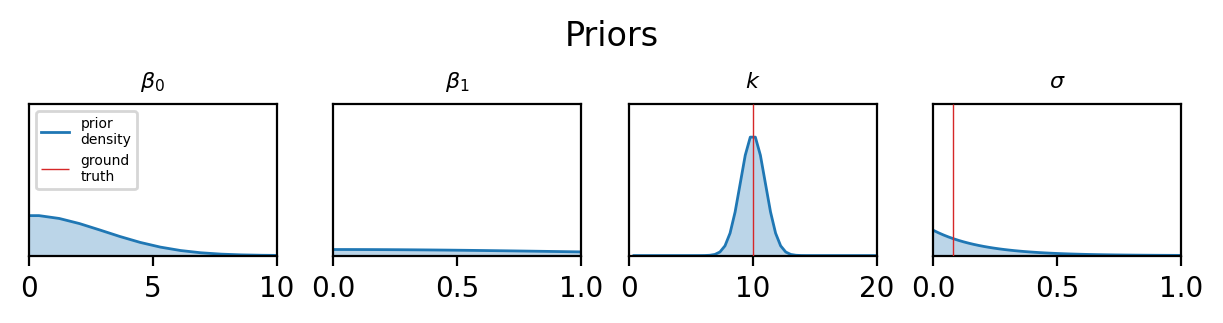

In [11]:
fig_prior, ax = plt.subplots(1, 4, figsize=(6,1.5), facecolor='white', dpi=200, constrained_layout=True)
fig_prior.suptitle('Priors')

ax[0].set_title(r'$\beta_0$', fontsize=8)
temp1 = jnp.linspace(-20, 20)
temp2 = jnp.exp(beta_0_prior.log_prob(temp1))
ax[0].plot(temp1, temp2, lw=1, zorder=2, label='prior\ndensity')
ax[0].fill_between(temp1, temp2, alpha=0.3, zorder=1)
ax[0].set_xlim(0, 10)
ax[0].set_ylim(0, 0.5)
ax[0].vlines(theta_true['beta_0'], 0, 0.5, lw=0.5, color='C3', zorder=3, label='ground\ntruth')
ax[0].legend(fontsize=5, loc='upper left')
ax[0].set_yticks([])

ax[1].set_title(r'$\beta_1$', fontsize=8)
temp1 = jnp.linspace(0, 1.0)
temp2 = jnp.exp(beta_1_prior.log_prob(temp1))
ax[1].plot(temp1, temp2, lw=1)
ax[1].fill_between(temp1, temp2, alpha=0.3)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 20)
ax[1].vlines(theta_true['beta_1'], 0, 20, lw=0.5, color='C3', zorder=3)
ax[1].set_yticks([])

ax[2].set_title(r'$k$', fontsize=8)
temp1 = jnp.linspace(0, 20)[1:]
temp2 = jnp.exp(k_prior.log_prob(temp1))
ax[2].plot(temp1, temp2, lw=1)
ax[2].fill_between(temp1, temp2, alpha=0.3)
ax[2].set_xlim(0, 20)
ax[2].set_ylim(0, 0.5)
ax[2].vlines(theta_true['k'], 0, 0.5, lw=0.5, color='C3', zorder=3)
ax[2].set_yticks([])

ax[3].set_title(r'$\sigma$', fontsize=8)
temp1 = jnp.linspace(0, 1)
temp2 = jnp.exp(sigma_prior.log_prob(temp1))
ax[3].plot(temp1, temp2, lw=1)
ax[3].fill_between(temp1, temp2, alpha=0.3)
ax[3].set_xlim(0, 1)
ax[3].set_ylim(0, 30)
ax[3].vlines(sigma, 0, 30, lw=0.5, color='C3', zorder=3)
ax[3].set_yticks([]);

We can also visualize the prior over the damping coefficient $b$ by sampling the prior and propagating the samples through the function $b(T) = \exp\{\beta_0 - \beta_1(T - 10)\}$. We see that our prior over $b$ is very wide (the 90% interval does not fit within the plotting window).

**Let's visualize the prior damping coefficient $b(T):$**

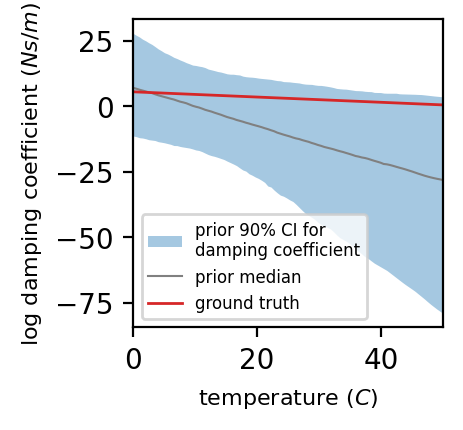

In [34]:
rng_key, rng_key_ = random.split(rng_key_)
with seed(rng_seed=rng_key[0]):
    beta_0_prior_samp = numpyro.sample('', beta_0_prior, sample_shape=(1000,))
    beta_1_prior_samp = numpyro.sample('', beta_1_prior, sample_shape=(1000,))
    k_prior_samp = numpyro.sample('', k_prior, sample_shape=(1000,))
    sigma_prior_samp = numpyro.sample('', sigma_prior, sample_shape=(1000,))

TT = jnp.linspace(0, 50, num=100)
logb_prior_samp = vmap(vmap(log_damping_coef, (0, None)), (None, 0))(TT, dict(beta_0=beta_0_prior_samp, beta_1=beta_1_prior_samp))
logb_true = vmap(log_damping_coef, (0, None))(TT, theta_true)

fig_b_prior, ax = plt.subplots(figsize=(2,2), facecolor='white', dpi=200)
b_prior_median = jnp.median(logb_prior_samp, axis=0)
b_prior_quant05 = jnp.quantile(logb_prior_samp, 0.05, axis=0)
b_prior_quant95 = jnp.quantile(logb_prior_samp, 0.95, axis=0)
ax.fill_between(TT, b_prior_quant05, b_prior_quant95, alpha=0.4, color='C0', lw=0, label='prior 90% CI for\ndamping coefficient')
# ax.fill_between(TT, b_prior_quant20, b_prior_quant80, alpha=0.4, color='C0', lw=0, label=r'prior $90\%$ CI for damping coefficient')
ax.plot(TT, b_prior_median, lw=0.75, color='gray', label='prior median')
ax.plot(TT, logb_true, lw=1, color='C3', label='ground truth')
ax.set_xlabel(r'temperature ($C$)', fontsize=8)
ax.set_ylabel(r'log damping coefficient ($Ns/m$)', fontsize=8)
ax.set_xlim(0,50)
# ax.set_ylim(-25,400)
ax.legend(fontsize=6);

**We now create our probabilistic model in NumPyro:**

Note that we have used the reparameterization trick on $\beta_0$. This helps make the posterior geometry nicer to sample from.

Another example of the reparameterization trick from the Numpyro documentation can be found [here](https://num.pyro.ai/en/latest/getting_started.html#a-simple-example-8-schools). More detailed reading on reparameterization for MCMC can be found [here](https://betanalpha.github.io/assets/case_studies/hierarchical_modeling.html).

## Sampling the Posterior

**We now use NumPyro's implementation of the No-U-Turn Sampler (NUTS) to sample from the posterior distribution:**

In [11]:
## Set up MCMC
nuts_kernel = NUTS(model, init_strategy=init_to_sample())
mcmc = MCMC(nuts_kernel, num_warmup=200, num_samples=400, num_chains=jax.local_device_count(), progress_bar=True)

## Run MCMC
rng_key, rng_key_ = random.split(rng_key_)
mcmc.run(rng_key, 
    m=m, 
    A=A, 
    omega=omega, 
    T=T, 
    t_meas=t_meas, 
    x_meas=x_meas, 
    beta_0_prior=beta_0_prior, 
    beta_1_prior=beta_1_prior, 
    k_prior=k_prior, 
    sigma_prior=sigma_prior
)
mcmc.print_summary()

## Store samples
samples = pd.DataFrame.from_dict(mcmc.get_samples())
beta_0_post_samp = mcmc.get_samples()['beta_0']
beta_1_post_samp = mcmc.get_samples()['beta_1']
k_post_samp = mcmc.get_samples()['k']
sigma_post_samp = mcmc.get_samples()['sigma']

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_0_decentered      0.43      0.01      0.43      0.41      0.45    819.60      1.00
             beta_1      0.10      0.02      0.10      0.08      0.13    674.80      1.00
                  k      8.87      0.97      8.82      7.15     10.24    645.20      1.00
              sigma      0.10      0.01      0.10      0.08      0.12    900.54      1.00

Number of divergences: 0


We see that NumPyro has sampled the posterior over all the latent parameters (i.e., the parameters in `model` for which we called `sample` but did not condition with an observation with `obs=...`). More specifically, 

**To assess how well the chain(s) converged, we can look at the trace plots:**

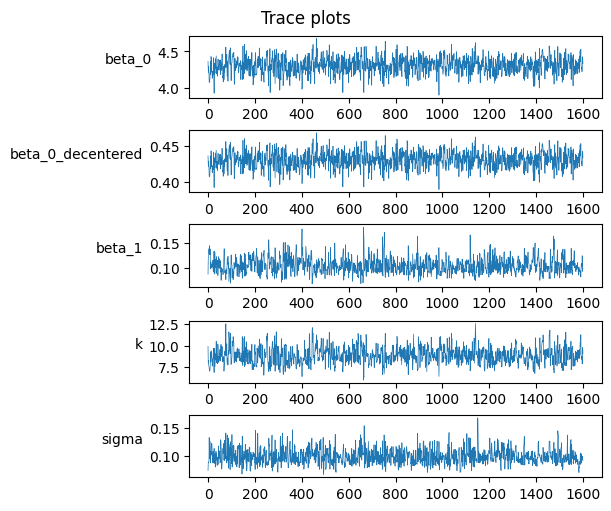

In [13]:
nparams = len(samples.columns)
fig, ax = plt.subplots(nparams, 1, figsize=(6,nparams), facecolor='white', layout='constrained')
fig.suptitle('Trace plots')
i = 0
for name, s in samples.items():
    ax[i].plot(s, lw=0.5)
    ax[i].set_ylabel(name, rotation=0, ha='right')
    i += 1


**To get a sense for how correlated the samples are, we can look at the autocorrelation plots:**

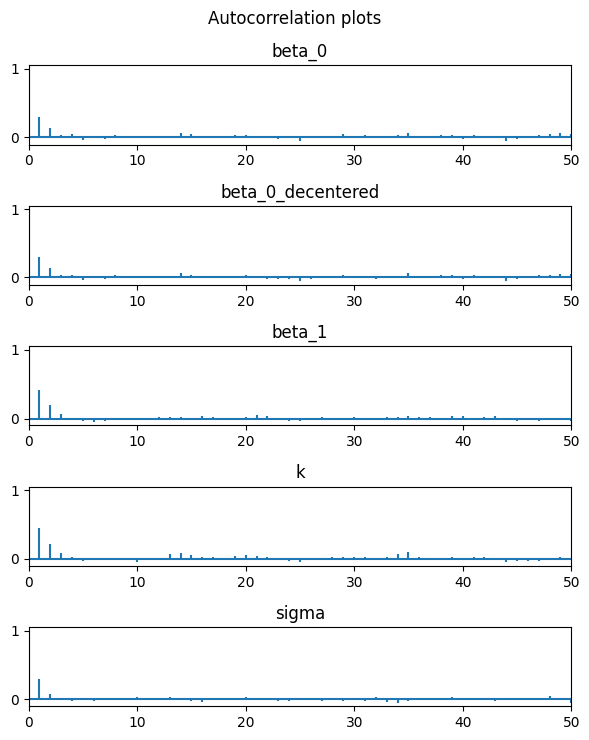

In [14]:
fig, ax = plt.subplots(nparams, 1, figsize=(6,1.5*nparams), facecolor='white', layout='tight')
fig.suptitle('Autocorrelation plots')
i = 0
for name, s in samples.items():
    ax[i].acorr(s[0:], detrend = plt.mlab.detrend_mean, maxlags=50)
    ax[i].set_xlim(0,50)
    ax[i].set_title(name)
    i += 1
samples_thinned = samples.copy() # no thinning

## Visualizing the posterior

Note that in this simple problem, the posterior captures the ground truth fairly well (as it should, since we used the correct model and relatively informative data).

**Let's compare the posterior against the prior for the parameters:**

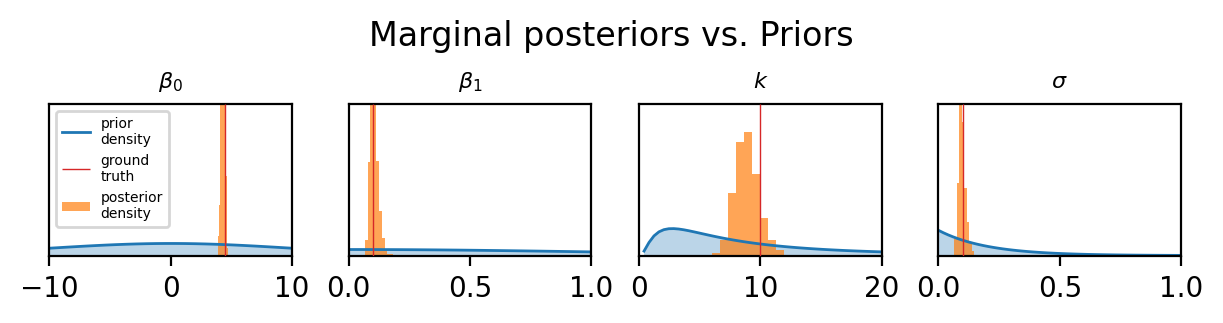

In [15]:
fig_prior.suptitle('Marginal posteriors vs. Priors')
fig_prior.axes[0].hist(np.array(beta_0_post_samp), density=True, color='C1', alpha=0.7, label='posterior\ndensity')
fig_prior.axes[1].hist(np.array(beta_1_post_samp), density=True, color='C1', alpha=0.7)
fig_prior.axes[2].hist(np.array(k_post_samp), density=True, color='C1', alpha=0.7)
fig_prior.axes[3].hist(np.array(sigma_post_samp), density=True, color='C1', alpha=0.7)
fig_prior.axes[0].legend(fontsize=5, loc='upper left')
fig_prior

We can also look that the posterior over position as a function of time, $x(t)$, for each of the three temperatures for which we had measurements (thick colored lines are the ground truth).

**Let's see the posterior position:**

In [16]:
## Compute some quantiles
t_ = jnp.linspace(0, 60, num=1000)
x_samp = []
median = []
quant05 = []
quant95 = []
for i, _T in enumerate(T):
    x_samp.append(deterministic_model_vectorized(t_, m, k, _T, beta_0_post_samp, beta_1_post_samp, A, omega))
    median.append(jnp.median(x_samp[i], axis=0))
    quant05.append(jnp.quantile(x_samp[i], 0.05, axis=0))
    quant95.append(jnp.quantile(x_samp[i], 0.95, axis=0))

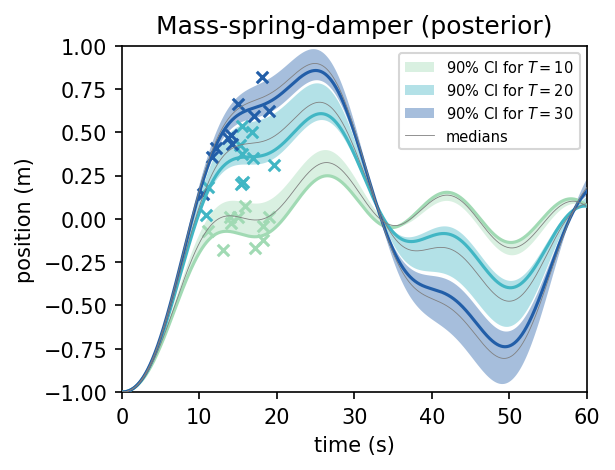

In [17]:
fig, ax = plt.subplots(facecolor='white', figsize=(4,3), dpi=150)
ax.set_title('Mass-spring-damper (posterior)')
ax.set_xlabel('time (s)')
ax.set_ylabel('position (m)')
ax.set_xlim([0,60])
ax.set_ylim([-1.0, 1.0])
colors = ['#a1dab4', '#41b6c4', '#225ea8']

ax.fill_between(t_, quant05[0], quant95[0], edgecolor=None, facecolor=colors[0], alpha=0.4, label=r'$90\%$ CI for $T={}$'.format(T[0]))
ax.fill_between(t_, quant05[1], quant95[1], edgecolor=None, facecolor=colors[1], alpha=0.4, label=r'$90\%$ CI for $T={}$'.format(T[1]))
ax.fill_between(t_, quant05[2], quant95[2], edgecolor=None, facecolor=colors[2], alpha=0.4, label=r'$90\%$ CI for $T={}$'.format(T[2]))

ax.scatter(t_meas[0], x_meas[0], 30, lw=1.5, marker='x', facecolor=colors[0], zorder=10)
ax.scatter(t_meas[1], x_meas[1], 30, lw=1.5, marker='x', facecolor=colors[1], zorder=10)
ax.scatter(t_meas[2], x_meas[2], 30, lw=1.5, marker='x', facecolor=colors[2], zorder=10)

ax.plot(t_dense, x_dense[0], lw=1.5, linestyle='-', color=colors[0], zorder=10)
ax.plot(t_dense, x_dense[1], lw=1.5, linestyle='-', color=colors[1], zorder=10)
ax.plot(t_dense, x_dense[2], lw=1.5, linestyle='-', color=colors[2], zorder=10)

ax.plot(t_, median[0], lw=0.4, linestyle='-', color='gray', zorder=100, label='medians')
ax.plot(t_, median[1], lw=0.4, linestyle='-', color='gray', zorder=100)
ax.plot(t_, median[2], lw=0.4, linestyle='-', color='gray', zorder=100)

ax.legend(fontsize=7);

**Finally, we can look at the posterior damping coefficient as a function of temperature, $b(T)$:**

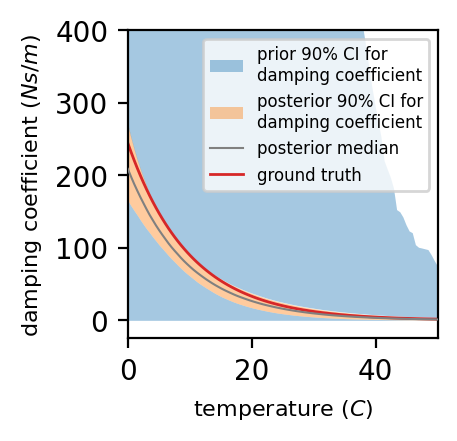

In [18]:
TT = jnp.linspace(0, 50, num=100)
b_post_samp = vmap(b_func, (None, 0, 0))(TT, beta_0_post_samp, beta_1_post_samp)
b_true = vmap(b_func, (0, None, None))(TT, beta_0, beta_1)

fig_b_post, ax = plt.subplots(figsize=(2,2), facecolor='white', dpi=200)
b_post_median = jnp.median(b_post_samp, axis=0)
b_post_quant05 = jnp.quantile(b_post_samp, 0.05, axis=0)
b_post_quant95 = jnp.quantile(b_post_samp, 0.95, axis=0)
ax.fill_between(TT, b_prior_quant05, b_post_quant05, alpha=0.4, color='C0', lw=0, label='prior 90% CI for\ndamping coefficient')
ax.fill_between(TT, b_post_quant05, b_post_quant95, alpha=0.4, color='C1', lw=0, label='posterior 90% CI for\ndamping coefficient')
ax.fill_between(TT, b_post_quant95, b_prior_quant95, alpha=0.4, color='C0', lw=0)
ax.plot(TT, b_post_median, lw=0.75, color='gray', label='posterior median', zorder=100)
ax.plot(TT, b_true, lw=1, color='C3', label='ground truth')
ax.set_xlabel(r'temperature ($C$)', fontsize=8)
ax.set_ylabel(r'damping coefficient ($Ns/m$)', fontsize=8)
ax.set_xlim(0,50)
ax.set_ylim(-25,400)
ax.legend(fontsize=6);